In [1]:
library(coda)
library(rjags)
library(R2jags)

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot




In [7]:
data <- read.csv("formatted_changes.csv")
reported <- data$reported
revised <- data$revised
N <- dim(data)[1]

In [22]:
model.loc <- ("lm_covariate.txt")
jagsscript <- cat("
model {  
   # priors on parameters
   u ~ dnorm(0, 0.01); 
   C ~ dnorm(0,0.01);
   inv.r ~ dgamma(0.001,0.001); 
   r <- 1/inv.r; 
   
   # likelihood
   for(i in 1:N) {
      X[i] <- u + C*c[i];
      EY[i] <- X[i]
      Y[i] ~ dnorm(EY[i], inv.r);
   }
}  
", 
    file = model.loc)

In [23]:
jags.data <- list(Y = revised, N = N, c = reported)
jags.params <- c("r", "EY", "u", "C")
mod_lm <- R2jags::jags(jags.data, parameters.to.save = jags.params, 
    model.file = model.loc, n.chains = 3, n.burnin = 5000, n.thin = 1, 
    n.iter = 10000, DIC = TRUE)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 50
   Unobserved stochastic nodes: 3
   Total graph size: 209

Initializing model



In [32]:
mod_lm

Inference for Bugs model at "lm_covariate.txt", fit using jags,
 3 chains, each with 10000 iterations (first 5000 discarded)
 n.sims = 15000 iterations saved
            mu.vect   sd.vect       2.5%        25%        50%        75%
C             0.997     0.007      0.983      0.993      0.997      1.002
EY[1]      9660.551    71.702   9521.100   9613.422   9660.512   9707.078
EY[2]     24748.538   183.604  24390.180  24627.603  24748.261  24867.669
EY[3]     24441.312   181.317  24087.438  24321.798  24441.090  24559.042
EY[4]     19821.950   146.955  19535.012  19725.301  19821.650  19917.284
EY[5]     18123.230   134.331  17861.014  18034.683  18123.014  18210.573
EY[6]     17645.434   130.782  17390.318  17559.284  17645.361  17730.365
EY[7]      7288.527    54.359   7183.387   7252.672   7288.712   7323.651
EY[8]      6096.530    45.746   6007.789   6066.281   6096.561   6126.067
EY[9]     24934.070   184.985  24572.901  24812.239  24933.873  25054.083
EY[10]    11296.429    83.74

In [24]:
plotModelOutput <- function(jagsmodel, Y) {
    # attach the model
    EY <- jagsmodel$BUGSoutput$sims.list$EY
    x <- seq(1, length(Y))
    summaryPredictions <- cbind(apply(EY, 2, quantile, 0.025), 
        apply(EY, 2, mean), apply(EY, 2, quantile, 0.975))
    plot(Y, col = "white", ylim = c(min(c(Y, summaryPredictions)), 
        max(c(Y, summaryPredictions))), xlab = "", ylab = "95% CIs of predictions and data", 
        main = paste("JAGS results:", jagsmodel$model.file))
    polygon(c(x, rev(x)), c(summaryPredictions[, 1], rev(summaryPredictions[, 
        3])), col = "grey70", border = NA)
    lines(summaryPredictions[, 2])
    points(Y)
}

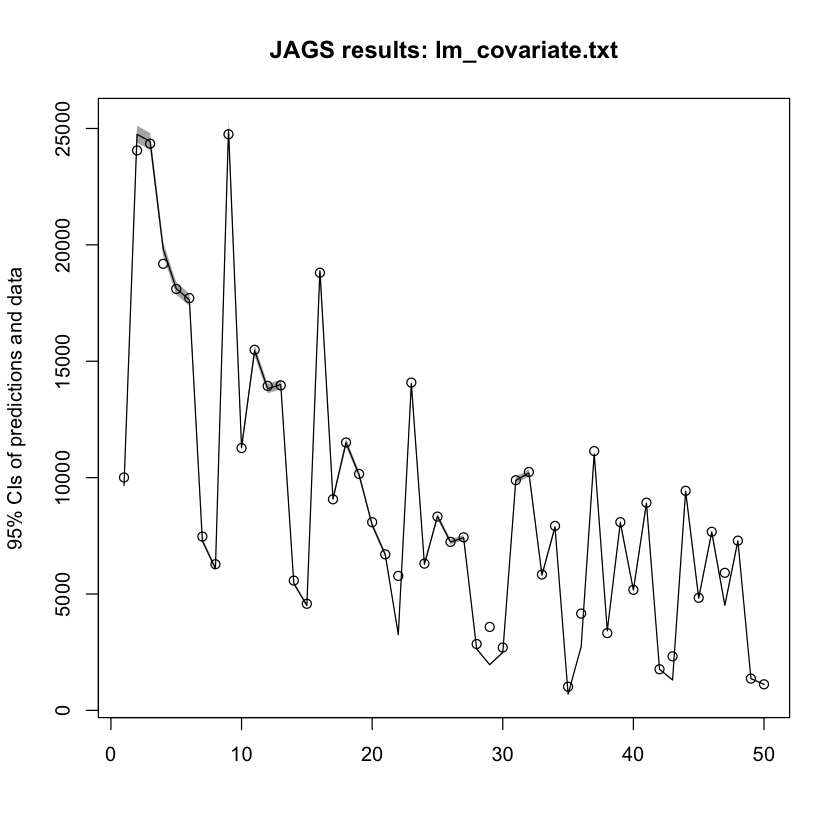

In [25]:
plotModelOutput(mod_lm, revised)

In [26]:
createMcmcList <- function(jagsmodel) {
    McmcArray <- as.array(jagsmodel$BUGSoutput$sims.array)
    McmcList <- vector("list", length = dim(McmcArray)[2])
    for (i in 1:length(McmcList)) McmcList[[i]] <- as.mcmc(McmcArray[, 
        i, ])
    McmcList <- mcmc.list(McmcList)
    return(McmcList)
}

In [27]:
myList<-createMcmcList(mod_lm)

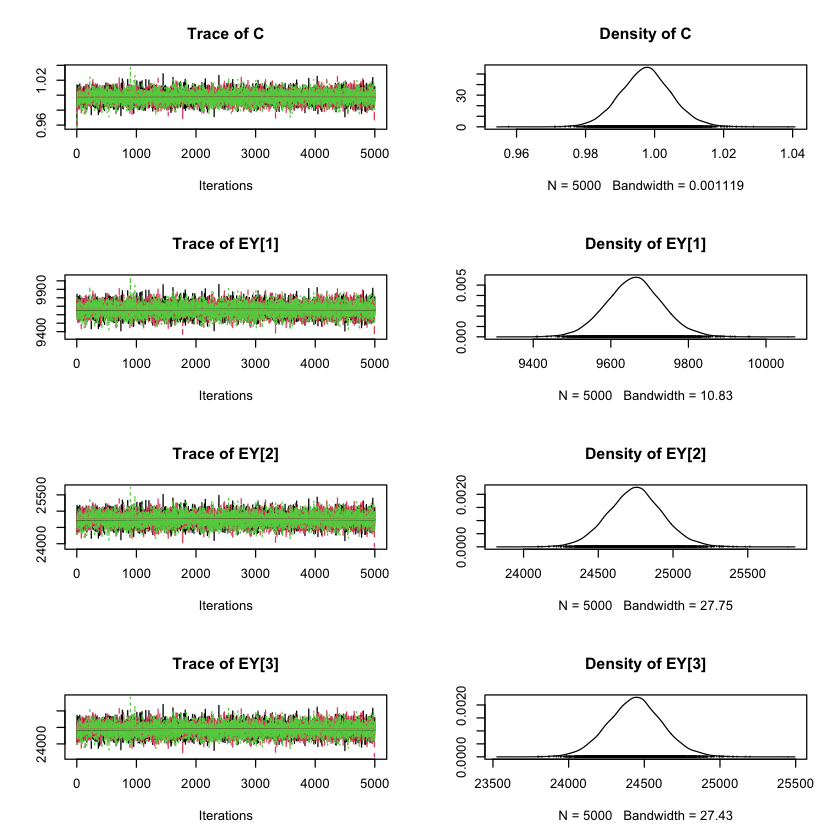

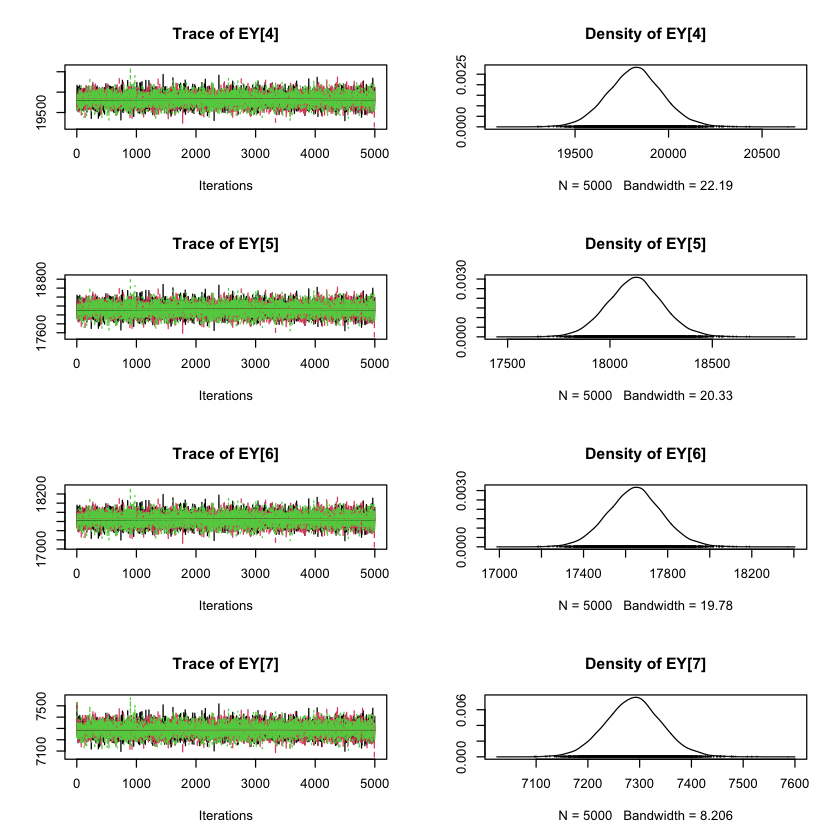

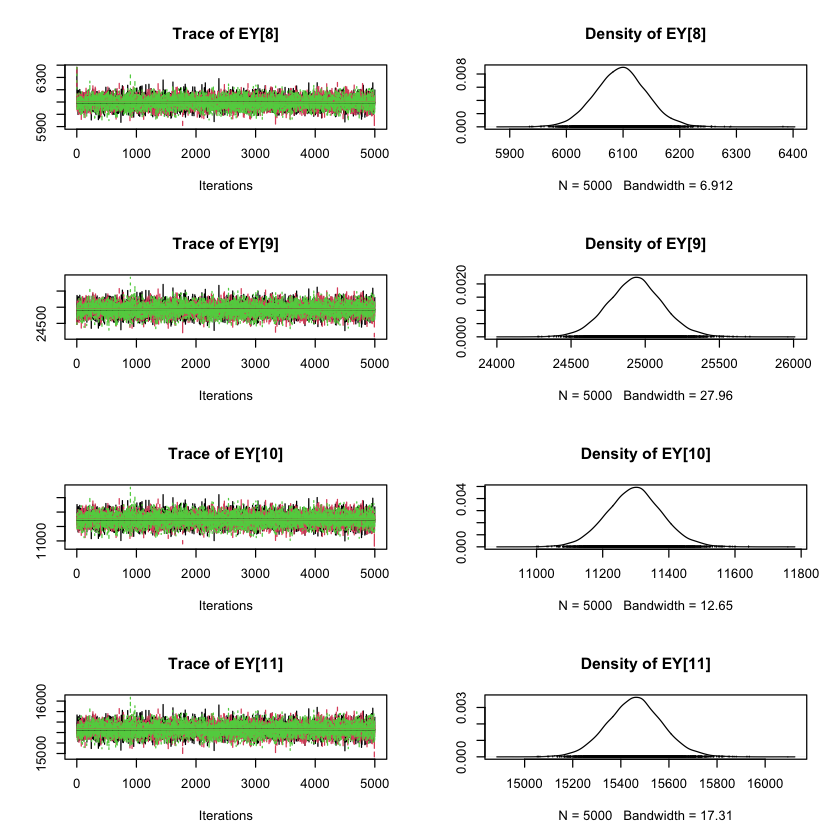

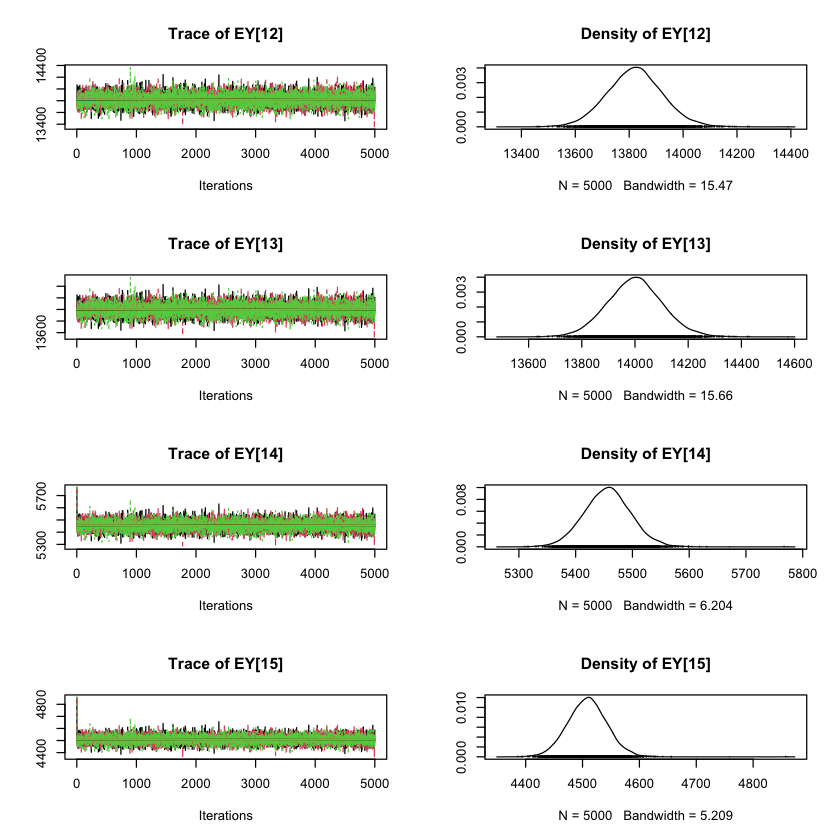

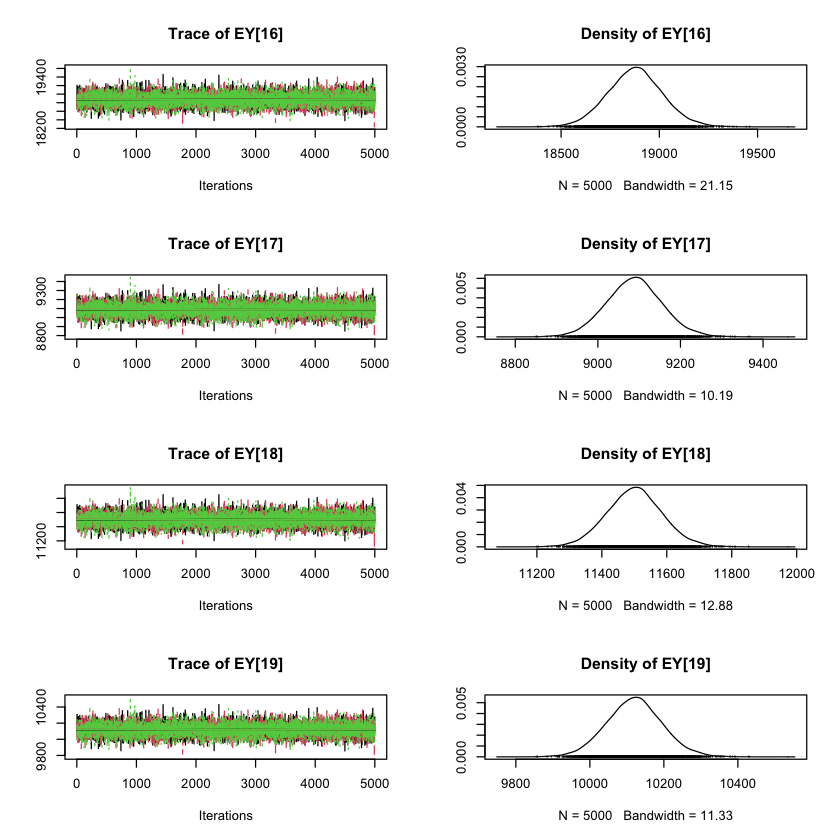

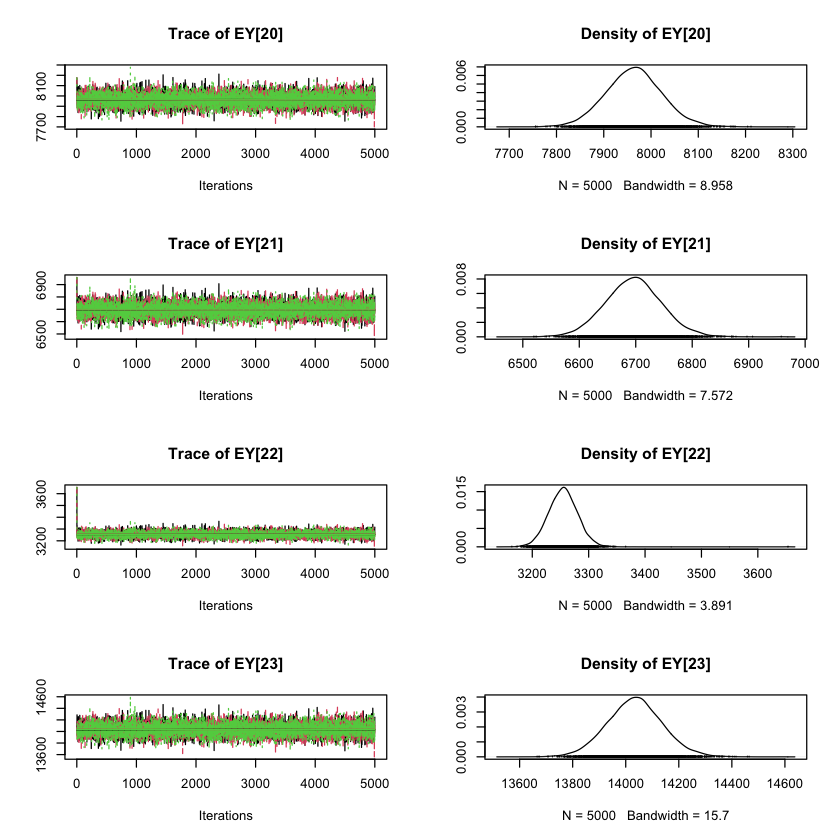

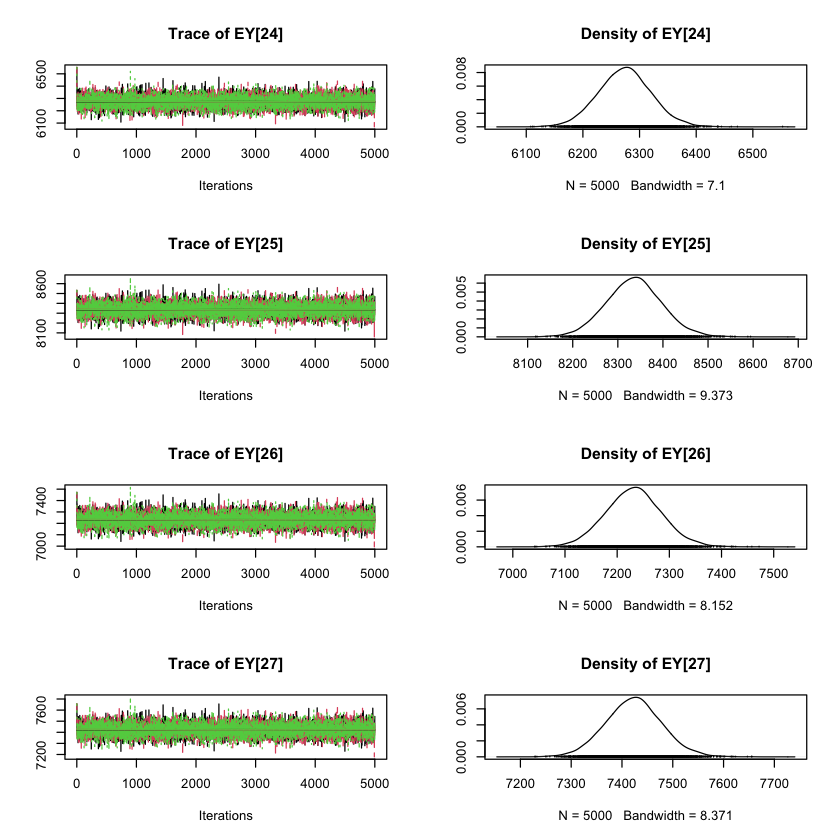

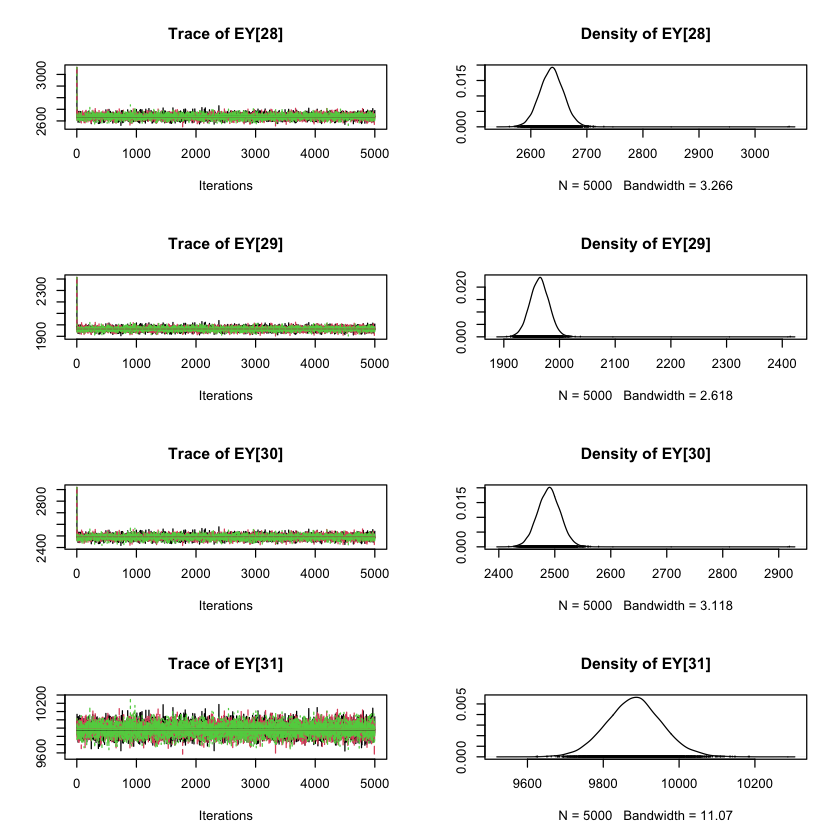

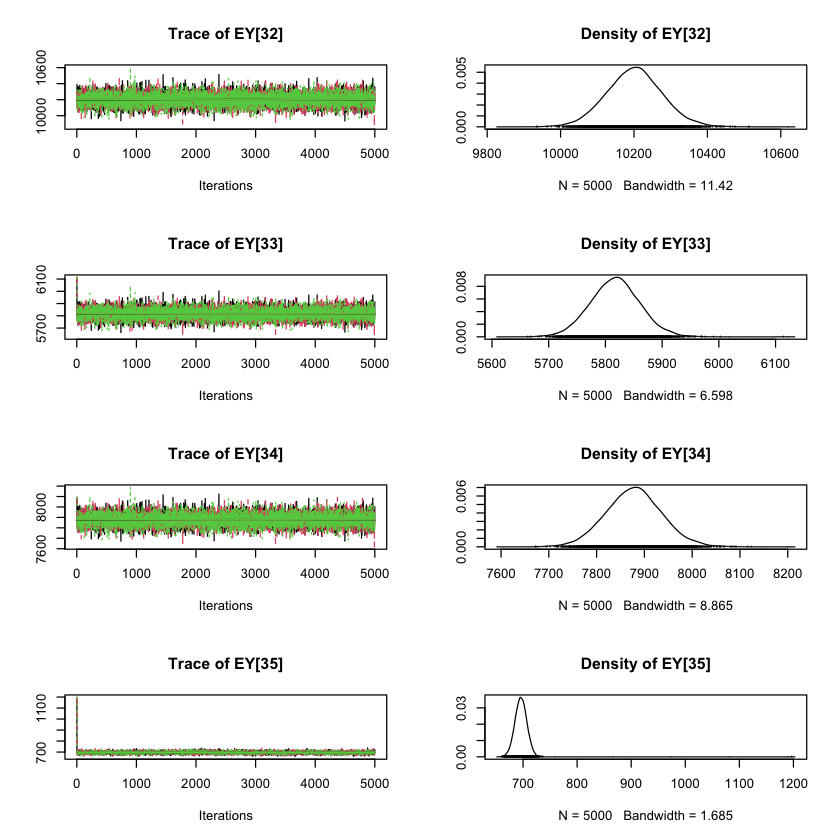

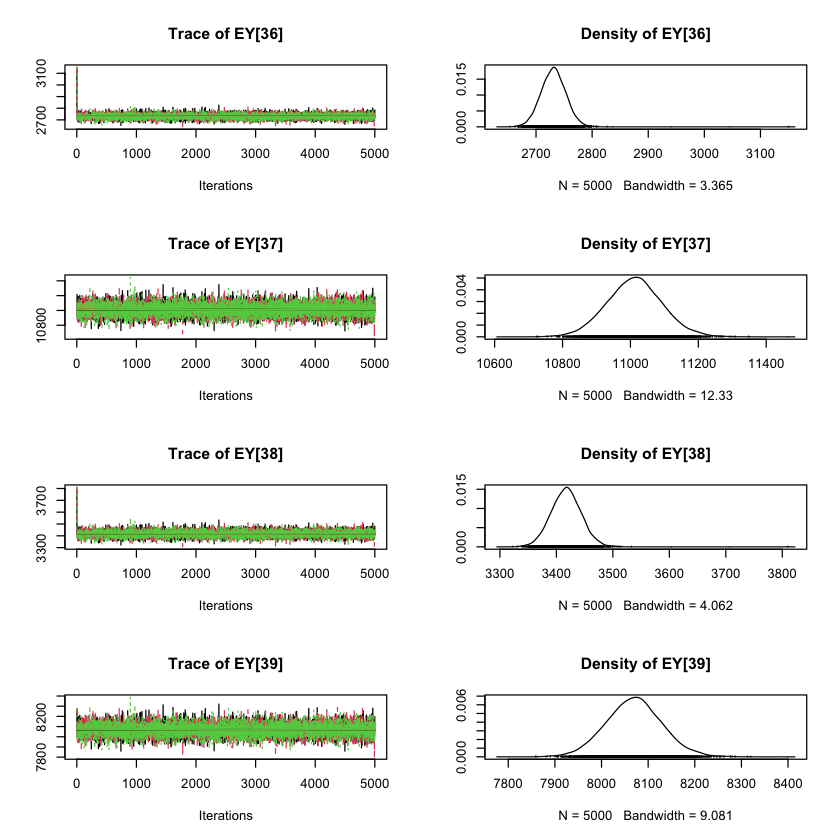

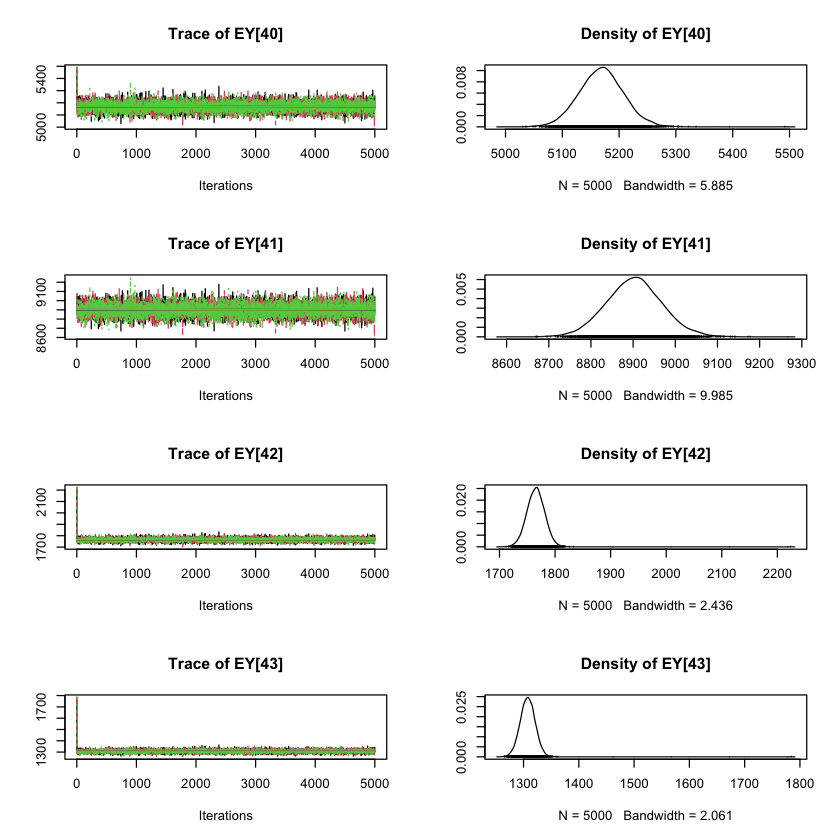

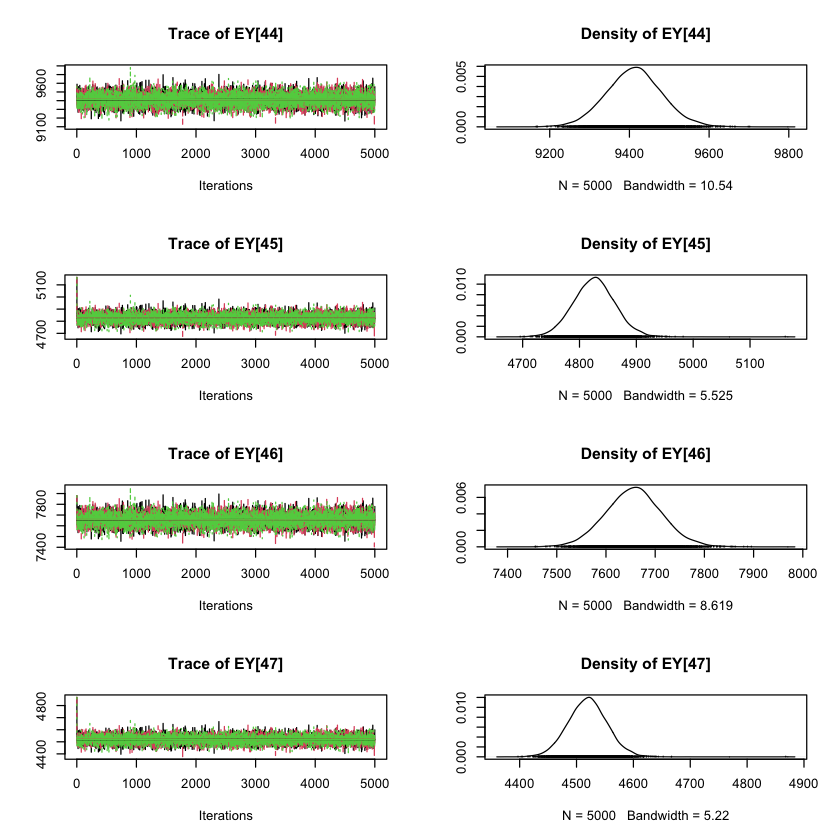

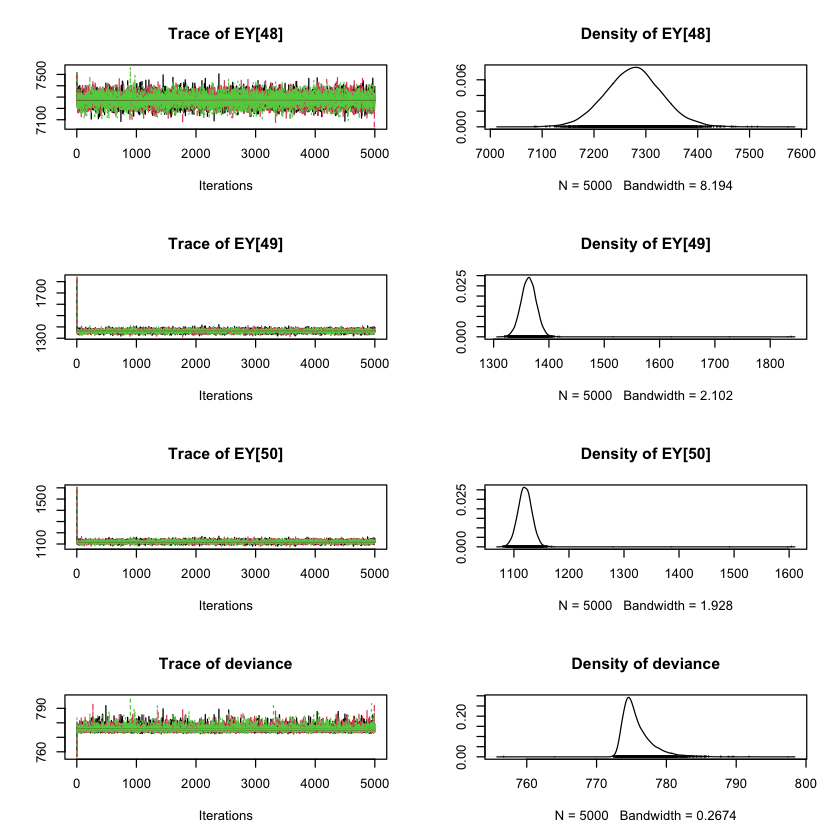

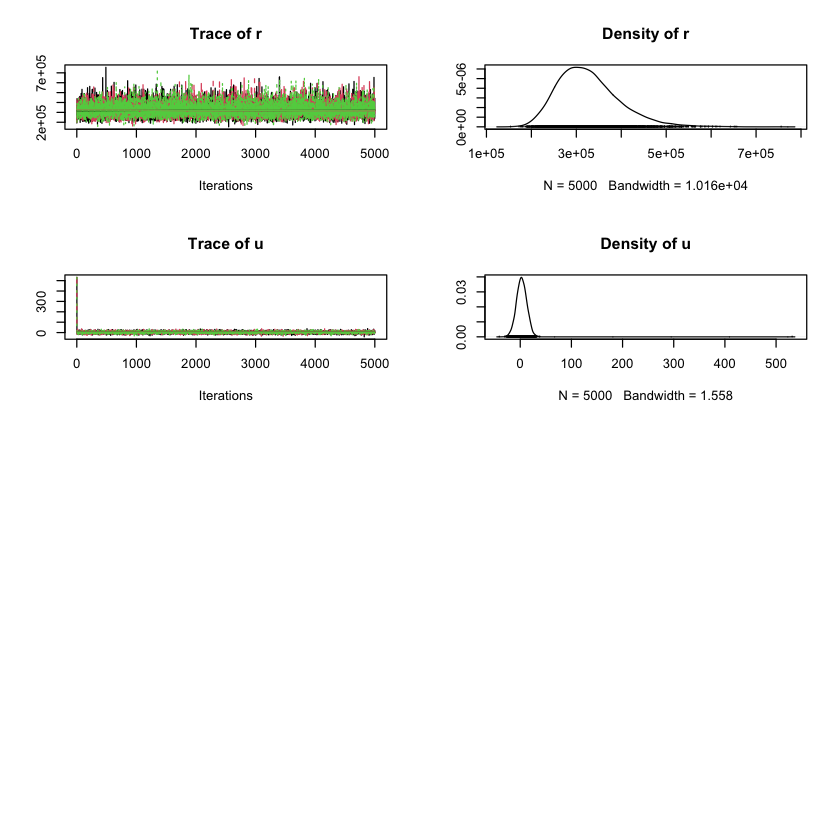

In [28]:
plot(myList)

In [31]:
summary(myList)


Iterations = 1:5000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 5000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

              Mean        SD  Naive SE Time-series SE
C        9.975e-01 7.442e-03 6.076e-05      6.077e-05
EY[1]    9.661e+03 7.170e+01 5.854e-01      5.855e-01
EY[2]    2.475e+04 1.836e+02 1.499e+00      1.499e+00
EY[3]    2.444e+04 1.813e+02 1.480e+00      1.481e+00
EY[4]    1.982e+04 1.470e+02 1.200e+00      1.200e+00
EY[5]    1.812e+04 1.343e+02 1.097e+00      1.097e+00
EY[6]    1.765e+04 1.308e+02 1.068e+00      1.068e+00
EY[7]    7.289e+03 5.436e+01 4.438e-01      4.439e-01
EY[8]    6.097e+03 4.575e+01 3.735e-01      3.735e-01
EY[9]    2.493e+04 1.850e+02 1.510e+00      1.510e+00
EY[10]   1.130e+04 8.375e+01 6.838e-01      6.838e-01
EY[11]   1.546e+04 1.146e+02 9.353e-01      9.354e-01
EY[12]   1.382e+04 1.024e+02 8.362e-01      8.363e-01
EY[13]   1.400e+04 1.037e+02 8.470e-01      8.471e

In [29]:
gelmanDiags <- coda::gelman.diag(myList, 
    multivariate = FALSE)
autocorDiags <- coda::autocorr.diag(myList)
gewekeDiags <- coda::geweke.diag(myList)
heidelDiags <- coda::heidel.diag(myList)

In [30]:
autocorDiags

,C,EY[1],EY[2],EY[3],EY[4],EY[5],EY[6],EY[7],EY[8],EY[9],⋯,EY[44],EY[45],EY[46],EY[47],EY[48],EY[49],EY[50],deviance,r,u
Lag 0,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000e+00,1.000000000,⋯,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000e+00
Lag 1,0.001490371,0.004483524,0.002580481,0.002594921,0.002869043,0.003007065,0.003050948,0.005562109,6.433906e-03,0.002571941,⋯,0.004569855,0.007833469,0.005348963,0.008281587,0.005569414,0.017451012,0.018003046,0.009837207,0.024294736,1.269988e-02
Lag 5,-0.001864818,-0.004898848,-0.003067454,-0.003082531,-0.003364991,-0.003504572,-0.003548593,-0.005816684,-6.503433e-03,-0.003058527,⋯,-0.004975246,-0.007509687,-0.005641461,-0.007807527,-0.005822638,-0.010195401,-0.009409343,-0.003206672,-0.010440322,2.498633e-05
Lag 10,-0.005211749,-0.004700994,-0.005085620,-0.005083425,-0.005039442,-0.005015679,-0.005007903,-0.004409700,-4.140770e-03,-0.005086912,⋯,-0.004679463,-0.003650736,-0.004471007,-0.003479109,-0.004407567,0.002286952,0.003207751,0.004075832,0.001249577,4.891450e-03
Lag 50,0.006967182,0.002714450,0.005417324,0.005396806,0.005007332,0.004811258,0.004748919,0.001183003,-5.484249e-05,0.005429458,⋯,0.002591867,-0.002042176,0.001485638,-0.002678512,0.001172630,-0.015619068,-0.016352048,0.006290086,-0.006261883,-8.424061e-03
